## Create basic evolution in a single figure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from functools import partial

out_figs = "out_figs"

In [2]:
nb_points = 400
range_points = np.linspace(1.8*np.pi, 5.2 * np.pi, nb_points)


x = [np.cos(i) * i / 5.0 for i in range_points]
y = [np.sin(i) * i / 5.0 for i in range_points]


/tmp/ipykernel_20581/370328248.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


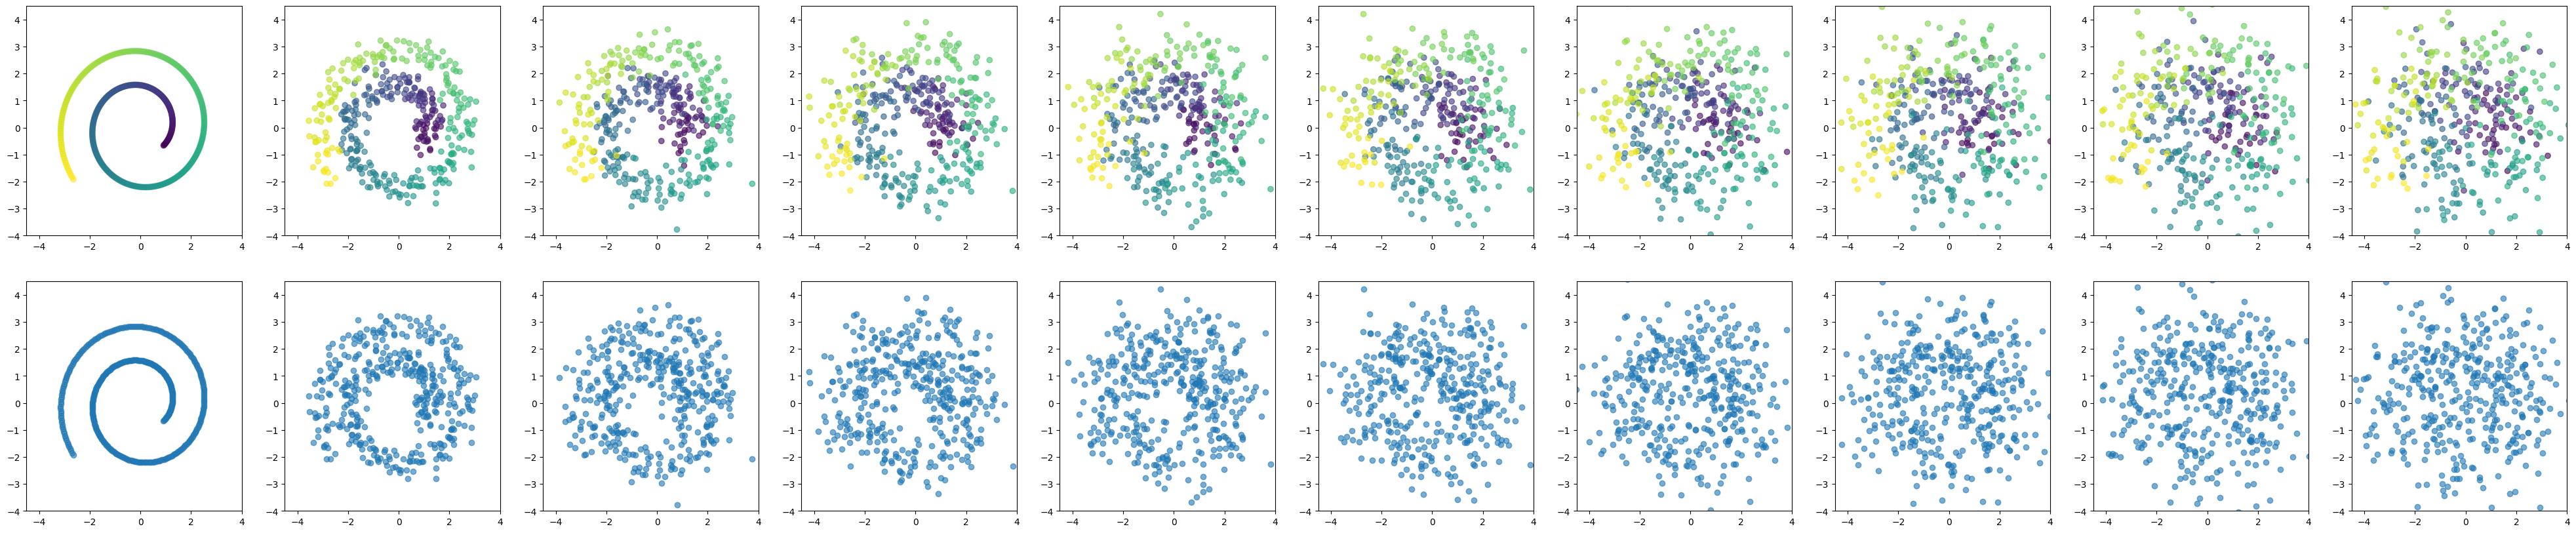

In [3]:
nb_figs = 10
fig, axs = plt.subplots(2, nb_figs, figsize=(5*nb_figs,5*2))
x_noisy, y_noisy = x, y
for i in range(nb_figs):
    axs[0, i].scatter(x_noisy, y_noisy, c=range_points, alpha=0.6)
    axs[0, i].set_xlim(-4.5, 4)
    axs[0, i].set_ylim(-4, 4.5)
    axs[1, i].scatter(x_noisy, y_noisy, alpha=0.6)
    axs[1, i].set_xlim(-4.5, 4)
    axs[1, i].set_ylim(-4, 4.5)
    noise_x = np.random.normal(0, 3.0/nb_figs, nb_points)
    noise_y = np.random.normal(0, 3.0/nb_figs, nb_points)
    x_noisy = x_noisy + noise_x
    y_noisy = y_noisy + noise_y
fig.show()

## Adapt functions from `annotated_diffusion.ipynb`

In [4]:
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose, Lambda, ToPILImage

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])


def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# forward diffusion
def q_sample(x_start, t, noise=None):
    if isinstance(x_start, list):
        print("Transforming into array")
        x_start = np.array(x_start)
    if noise is None:
        noise = np.random.normal(0, 1, x_start.shape)
    elif isinstance(noise, float):
        noise = np.random.normal(0, noise, x_start.shape)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def q_sample_numerous(x_start, y_start, nb_steps, std=None):
    x_sampled = []
    y_sampled = []

    if isinstance(x_start, list):
        x_start = np.array(x_start)
    if isinstance(y_start, list):
        y_start = np.array(y_start)

    for t in range(nb_steps):
        x_sampled.append(q_sample(x_start, torch.tensor([t]), std))
        y_sampled.append(q_sample(y_start, torch.tensor([t]), std))

    x_sampled = np.array(x_sampled)
    y_sampled = np.array(y_sampled)

    return x_sampled, y_sampled


/tmp/ipykernel_20581/2816997970.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
/tmp/ipykernel_20581/2510411286.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


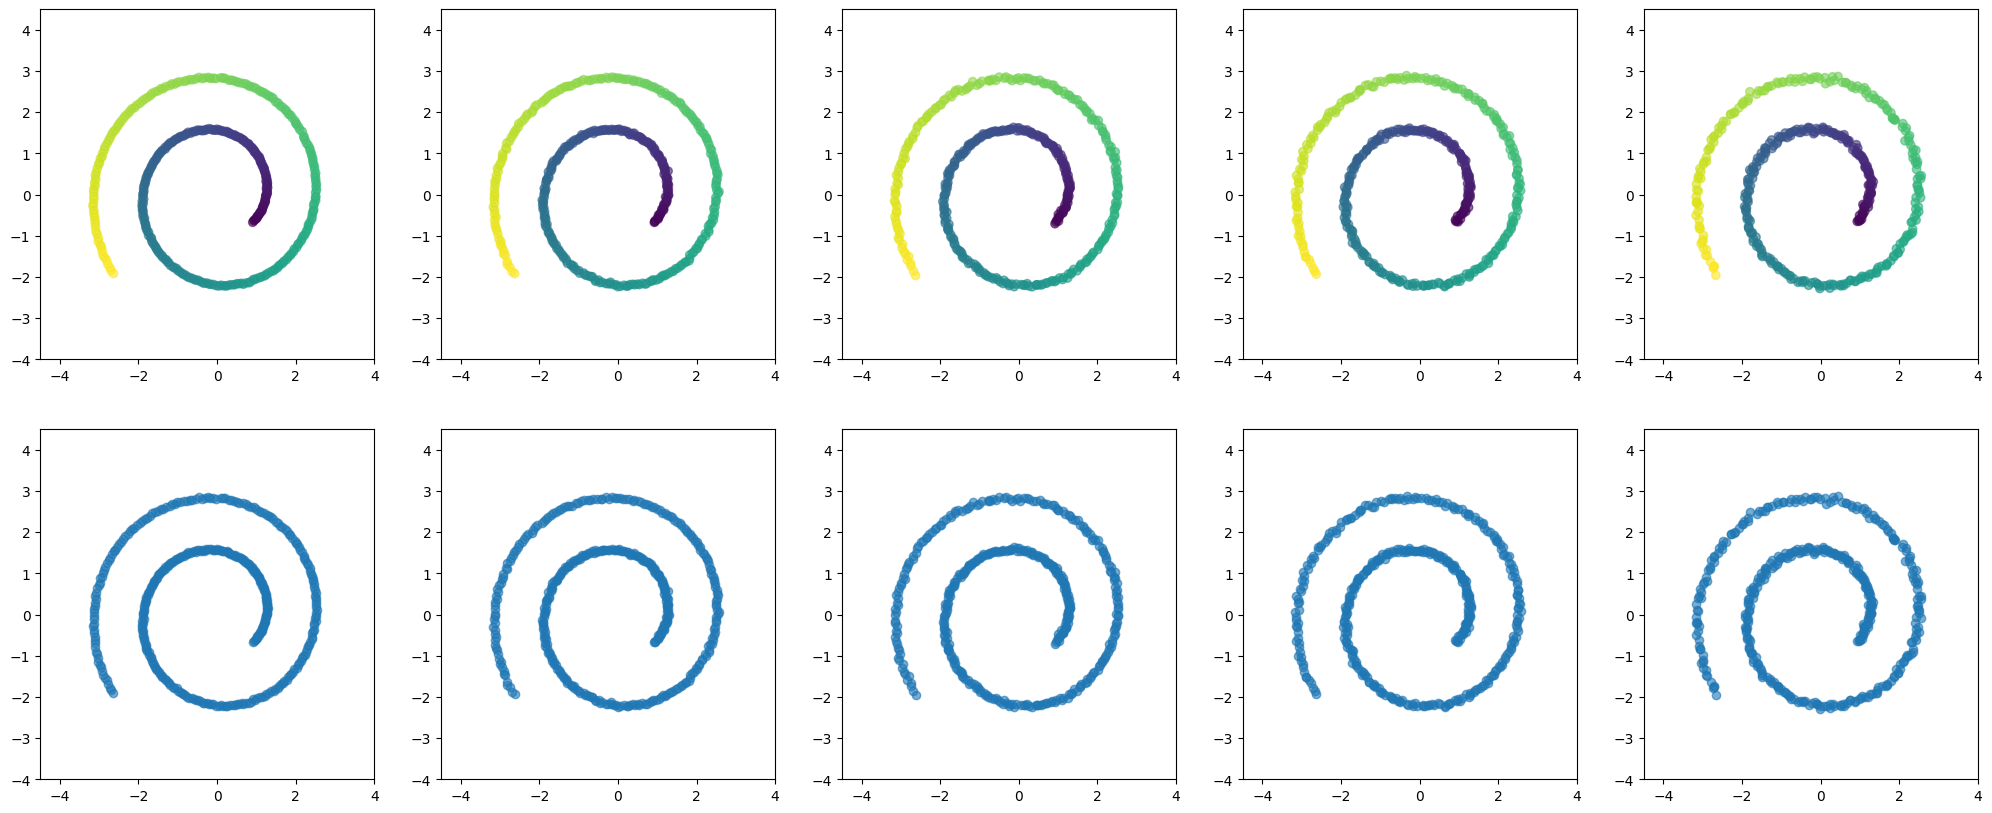

In [5]:
nb_figs = 5

x_sampled, y_sampled = q_sample_numerous(x, y, nb_figs)

fig, axs = plt.subplots(2, nb_figs, figsize=(5*nb_figs,5*2))
for i in range(nb_figs):
    axs[0, i].scatter(x_sampled[i], y_sampled[i], c=range_points, alpha=0.6)
    axs[0, i].set_xlim(-4.5, 4)
    axs[0, i].set_ylim(-4, 4.5)
    axs[1, i].scatter(x_sampled[i], y_sampled[i], alpha=0.6)
    axs[1, i].set_xlim(-4.5, 4)
    axs[1, i].set_ylim(-4, 4.5)
fig.show()

In [6]:
def progressive_noise(x, nb_steps=50, stdv=0.2):
    n = len(x)
    x_noisy = np.zeros((nb_steps, n))
    x_noisy[0] = x
    for i in range(1, nb_steps):
        prev_x = x_noisy[i-1]
        noise = np.random.normal(0, stdv, n)
        x_noisy[i] = prev_x + noise
    return x_noisy

In [7]:
x_noisy, y_noisy = progressive_noise(x), progressive_noise(y)

In [8]:
import glob
import os
from PIL import Image
import re

def save_pngs(p_x, p_y, colored = True, folder = None):
    if folder is None:
        folder = os.path.join(out_figs, "pngs")
    if not os.path.exists(folder):
        os.makedirs(folder)
    xmin, xmax = min(p_x[-1]), max(p_x[-1])
    xmin, xmax = xmin - 0.1*(xmax-xmin), xmax + 0.1*(xmax-xmin)
    ymin, ymax = min(p_y[-1]), max(p_y[-1])
    ymin, ymax = ymin - 0.1*(xmax-xmin), ymax + 0.1*(xmax-xmin)
    for i in range(p_x.shape[0]):
        fig, ax = plt.subplots()
        ax.scatter(p_x[i], p_y[i], c= np.linspace(0, 1, p_x.shape[1]) if colored else None)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        fig.savefig(os.path.join(folder, f"noisy_swiss_roll_{i if i >= 10 else "0"+str(i)}.png"))
        plt.close()

def numerical_sort(value):
    parts = re.findall(r'(\d+|\D+)', value)
    return tuple(int(part) if part.isdigit() else part for part in parts)

def save_gif(folder=None, prefix="noisy_swiss_roll", delete=False, name=None):
    if folder is None:
        folder = os.path.join(out_figs, "pngs")
    base = os.path.join(folder, prefix + f"{'_' if prefix else ''}")
    
    imgs = glob.glob(base + "*.png")
    imgs.sort(key=numerical_sort)  # Sort by name
    
    anim = []
    for img_i in imgs:
        curr_img = Image.open(img_i)
        anim.append(curr_img)
    
    if name is None:
        # Find the next available filename
        i = 0
        while True:
            gif_name = base + f"evolution_{i}.gif"
            if not os.path.exists(gif_name):
                break
            i += 1
    else:
        gif_name = os.path.join(folder, name + ".gif")
    
    anim[0].save(gif_name, save_all = True, append_images = anim[1:],
                 loop = 0, duration = 100)
    
    if delete:
        for img_i in imgs:
            os.remove(img_i)

In [9]:
out_dir = os.path.join(out_figs, "with_my_noise_def")
gif_name = "evolution_with_my_noise_def"
save_pngs(x_noisy, y_noisy, folder = out_dir)
save_gif(folder = out_dir, name=gif_name)

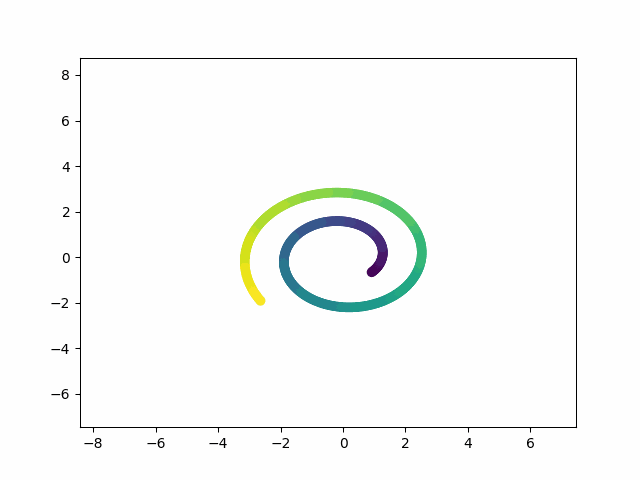

In [10]:
from IPython.display import Image as IP_Image
IP_Image(filename=os.path.join(out_dir, gif_name + ".gif"))

In [11]:
out_dir = os.path.join(out_figs, "with_q_sample")
gif_name = "evolution_with_q_sample"
x_sampled, y_sampled = q_sample_numerous(x, y, 50, std=3.0)
save_pngs(x_sampled, y_sampled, folder = out_dir)
save_gif(folder = out_dir, name=gif_name)

/tmp/ipykernel_20581/2816997970.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


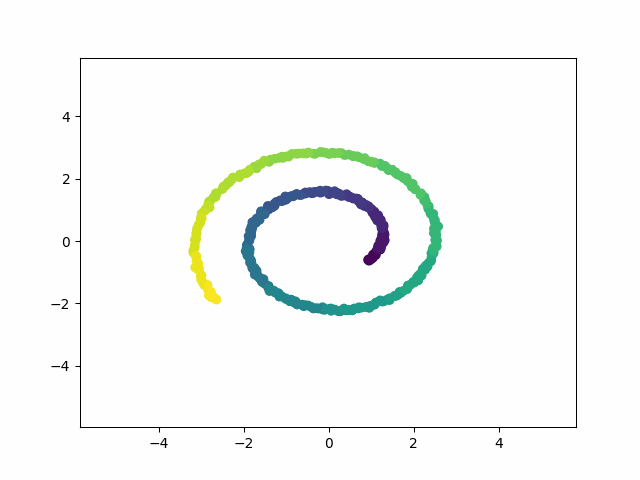

In [12]:
from IPython.display import Image as IP_Image
IP_Image(filename=os.path.join(out_dir, gif_name + ".gif"))